In [1]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
TRAIN_DATASET_PATH = 'C:/Users/Spectra/Dropbox/Geekbrains/1 четверть/Numpy Pandas/Курсовая/train.csv'
TEST_DATASET_PATH = 'C:/Users/Spectra/Dropbox/Geekbrains/1 четверть/Numpy Pandas/Курсовая/test.csv'

In [3]:
def apply_elbow_method(X):
    """
    Функция для оценки оптимального кол-ва кластеров методом локтя
    """
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    
def display_components_in_2D_space(components_df, labels=None):
    """
    Функция для визуализации работы алгоритма понижения размерности в 2-D пространство
    """
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=labels.name, cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=(15,10))
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15,10))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

    
def reduce_dims_with_PCA(df, n):
    """
    Функция для понижения размерности исходных данных методом PCA
    n - число компонент (доступные значения: 2, 3)
    """
    pca = PCA(n_components=n)
    components = pca.fit_transform(df)
    if n==2:
        reduced_df = pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    elif n==3:
        reduced_df = pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])
    else:
        print('Число компонент больше 3 в данной функции не поддержиается')
    return reduced_df    

In [4]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [6]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [7]:
train_df.shape

(10000, 20)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


УМЕНЬШАЕМ ДАННЫЕ из 64 в формат 32

In [10]:
list_to_float32=list(train_df.dtypes[train_df.dtypes=='float64'].index); print(len(list_to_float32))
list_to_int32=list(train_df.dtypes[train_df.dtypes=='int64'].index); print(len(list_to_int32))
list_oth=list(train_df.dtypes[(train_df.dtypes!='float64')&(train_df.dtypes!='int64')].index); print(len(list_oth))

train_df = pd.concat([train_df[list_oth]
              , train_df[list_to_float32].astype('float32')
              , train_df[list_to_int32].astype('int32')], axis=1)
print(train_df.dtypes.value_counts())
print(train_df.shape)

8
9
3
int32      9
float32    8
object     3
dtype: int64
(10000, 20)


СМОТРИМ НА ЦЕЛЕВУЮ ПЕРЕМЕННУЮ

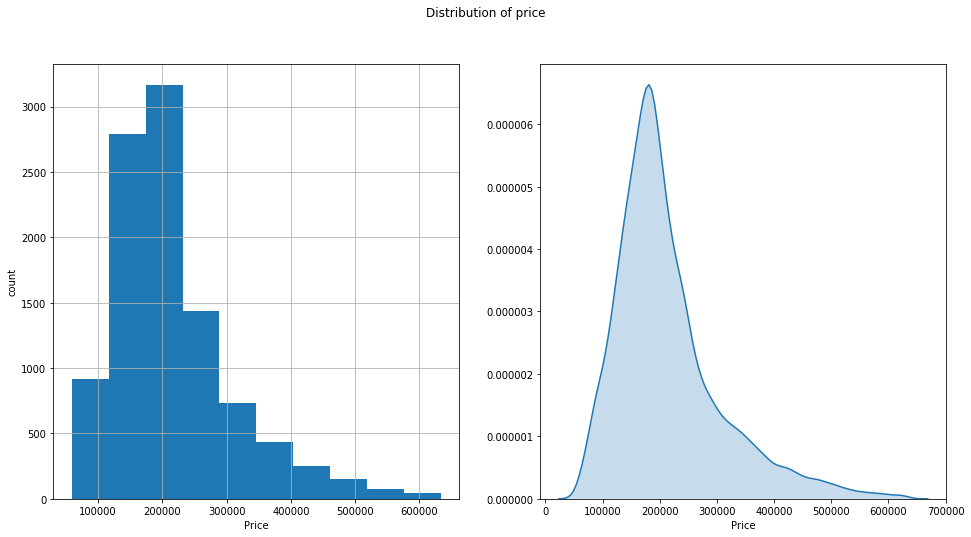

In [11]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of price')
plt.show()

ОБРАБОТКА ПРОПУСКОВ

In [12]:
df_obj_features = train_df.select_dtypes(include=['object', 'bool'])
df_obj_features

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,A
9997,B,B,A
9998,B,A,B


In [13]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [14]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [15]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [16]:
print(len(train_df) - train_df.count())
train_df.isnull().sum()

Ecology_2           0
Ecology_3           0
Shops_2             0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
HouseFloor          0
Ecology_1           0
Healthcare_1     4798
Price               0
Id                  0
DistrictId          0
Floor               0
HouseYear           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Shops_1             0
dtype: int64


Ecology_2           0
Ecology_3           0
Shops_2             0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
HouseFloor          0
Ecology_1           0
Healthcare_1     4798
Price               0
Id                  0
DistrictId          0
Floor               0
HouseYear           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Shops_1             0
dtype: int64

In [17]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

In [18]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

ОБРАБОТКА ВЫБРОСОВ

In [19]:
train_df[train_df['HouseFloor'] == 0]

,Ecology_2,Ecology_3,Shops_2,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1,Price,Id,DistrictId,Floor,HouseYear,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
7,B,B,B,2.0,80.312927,32.781261,0.0,0.0,0.075779,900.0,221244.15625,11993,74,14,1977,6,1437,3,0,2
23,B,B,B,3.0,118.907608,32.781261,0.0,0.0,0.006076,645.0,571069.06250,6641,54,2,1977,30,5285,0,6,6
26,B,B,A,3.0,106.958870,0.641822,0.0,0.0,0.072158,900.0,337299.87500,4378,27,17,2018,2,629,1,0,0
39,B,B,B,2.0,60.503250,32.781261,0.0,0.0,0.034656,900.0,229778.06250,9371,23,16,1977,0,168,0,0,0
44,B,B,B,3.0,104.211395,106.340401,0.0,0.0,0.060753,520.0,435462.06250,10521,38,20,2017,15,2787,2,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,B,B,B,1.0,46.072914,48.307846,0.0,0.0,0.000078,1046.0,161403.09375,12302,30,4,1977,22,6398,141,3,23
9769,B,B,B,3.0,98.607330,32.781261,0.0,0.0,0.019509,176.0,492700.25000,9384,59,14,1977,37,7687,11,5,5
9878,B,B,A,2.0,71.985336,72.453232,0.0,0.0,0.072158,900.0,158841.62500,11441,62,5,1977,2,629,1,0,0
9908,B,B,A,1.0,35.873962,32.781261,0.0,0.0,0.072158,900.0,134379.12500,3171,62,25,1977,2,629,1,0,0


In [20]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [21]:
train_df.loc[train_df['Ecology_1'] == 0, 'Ecology_1'] = train_df['Ecology_1'].median()

In [22]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839523,0.000000e+00,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315712,21.058718,1.136859e+00,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,10000.0,36.266048,76.609917,3.706194e-01,25.527400,32.781261,41.427234,7.480592e+03
KitchenSquare,10000.0,6.273300,28.561113,0.000000e+00,1.000000,6.000000,9.000000,2.014000e+03
HouseFloor,10000.0,12.959100,6.443546,1.000000e+00,9.000000,13.000000,17.000000,1.170000e+02
Ecology_1,10000.0,0.122908,0.116162,1.800000e-09,0.034656,0.075424,0.195781,5.218670e-01
Healthcare_1,10000.0,1026.358887,746.645447,0.000000e+00,830.000000,900.000000,990.000000,4.849000e+03
Price,10000.0,214139.218750,92872.304688,5.917478e+04,153872.628906,192269.648438,249135.460938,6.332334e+05
Id,10000.0,8383.407700,4859.019020,0.000000e+00,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000e+00,20.000000,36.000000,75.000000,2.090000e+02


In [23]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [24]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011

In [25]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [26]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [27]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [28]:
train_df.loc[train_df['KitchenSquare'] > 680, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [29]:
train_df.loc[train_df['LifeSquare'] > 680, 'LifeSquare'] = train_df['LifeSquare'].median()

In [30]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'], prefix='Ecology_2')], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'], prefix='Ecology_3')], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'], prefix='Shops_2')], axis=1)

ОЦЕНКА ОПТИМАЛЬНОГО КОЛИЧЕСТВА КЛАСТЕРОВ

In [31]:
train_df.drop(['Ecology_2'], axis = 1, inplace = True)
train_df.drop(['Ecology_3'], axis = 1, inplace = True)
train_df.drop(['Shops_2'], axis = 1, inplace = True)
train_df.dtypes

Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
HouseFloor       float32
Ecology_1        float32
Healthcare_1     float32
Price            float32
Id                 int32
DistrictId         int32
Floor              int32
HouseYear          int32
Social_1           int32
Social_2           int32
Social_3           int32
Helthcare_2        int32
Shops_1            int32
Ecology_2_A        uint8
Ecology_2_B        uint8
Ecology_3_A        uint8
Ecology_3_B        uint8
Shops_2_A          uint8
Shops_2_B          uint8
dtype: object

In [32]:
df_features = train_df.drop('Price', axis=1)
df_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1,Id,DistrictId,Floor,...,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,2.0,47.981560,29.442751,6.0,9.0,0.089040,900.0,14038,35,7,...,7976,5,0,11,0,1,0,1,0,1
1,3.0,65.683640,40.049541,8.0,9.0,0.000070,240.0,15053,41,7,...,10309,1,1,16,0,1,0,1,0,1
2,2.0,44.947952,29.197611,6.0,12.0,0.049637,229.0,4765,53,8,...,7759,0,1,3,0,1,0,1,0,1
3,2.0,53.352982,52.731510,9.0,17.0,0.437885,1084.0,5809,58,8,...,5735,3,0,5,0,1,0,1,0,1
4,1.0,39.649193,23.776169,7.0,12.0,0.012339,2078.0,10783,99,11,...,5776,1,2,4,0,1,0,1,0,1


In [33]:
from sklearn.preprocessing import StandardScaler

df_cat = df_features[df_features.columns[-5:]]
df_num = df_features[df_features.columns[:-5]]

scaler = StandardScaler()
df_features.select_dtypes(['int32', 'float32'])

df_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

In [34]:
df_scaled = pd.concat([df_scaled, df_cat], axis=1)
df_scaled.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1,Id,DistrictId,Floor,...,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0.130439,-0.395780,-0.348137,-0.384014,-0.614468,-0.291578,-0.169240,1.163789,-0.353348,-0.291306,...,0.654880,-0.127533,-0.883480,1.408356,-0.09897,1,0,1,0,1
1,1.321667,0.444867,0.246292,0.119314,-0.614468,-1.057538,-1.053217,1.372690,-0.215687,-0.291306,...,1.237169,-0.295384,-0.213923,2.448700,-0.09897,1,0,1,0,1
2,0.130439,-0.539842,-0.361875,-0.384014,-0.148856,-0.630802,-1.067950,-0.744716,0.059635,-0.100498,...,0.600720,-0.337347,-0.213923,-0.256195,-0.09897,1,0,1,0,1
3,0.130439,-0.140699,0.957019,0.370978,0.627163,2.711711,0.077202,-0.529847,0.174352,-0.100498,...,0.095553,-0.211458,-0.883480,0.159943,-0.09897,1,0,1,0,1
4,-1.060788,-0.791473,-0.665705,-0.132350,-0.148856,-0.951912,1.408526,0.493868,1.115034,0.471924,...,0.105786,-0.295384,0.455633,-0.048126,-0.09897,1,0,1,0,1


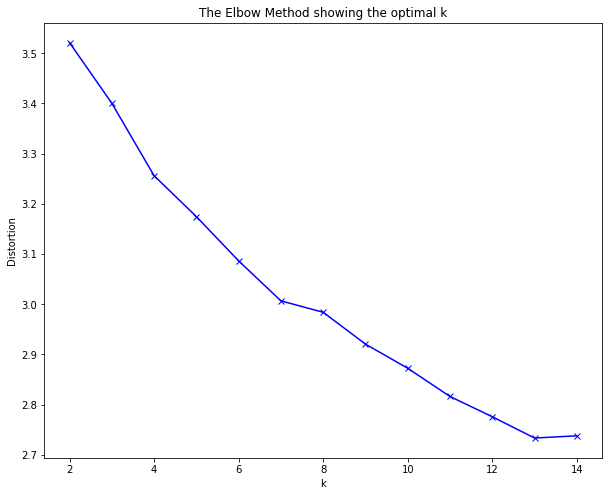

In [35]:
apply_elbow_method(df_scaled)

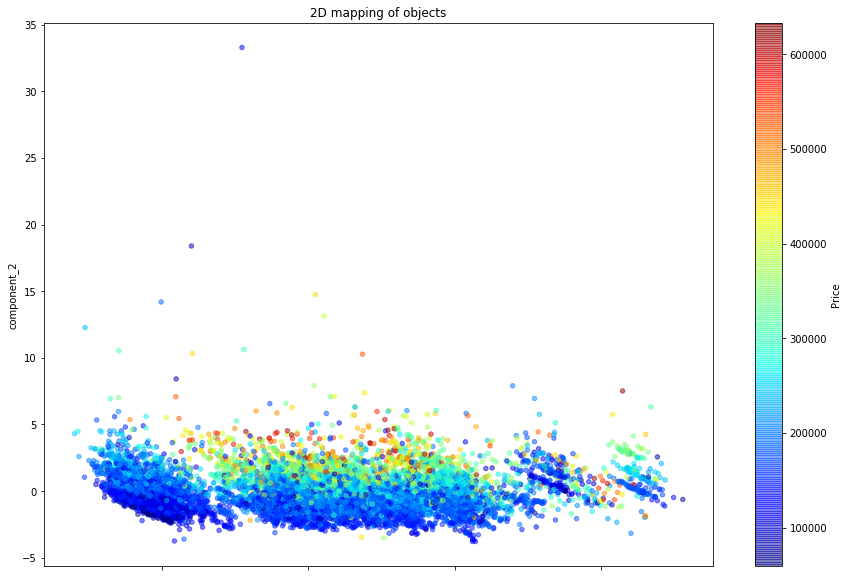

In [36]:
components_2d = reduce_dims_with_PCA(df_scaled, n=2)
display_components_in_2D_space(components_2d, train_df['Price'])

In [37]:
def display_clusters_distribution(unique_labels, labels_counts):
    """
    Функция для визуализации распределения объектов по кластерам
    """
    plt.figure(figsize=(8,5))
    plt.bar(unique, counts)
    plt.xlabel('Clгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

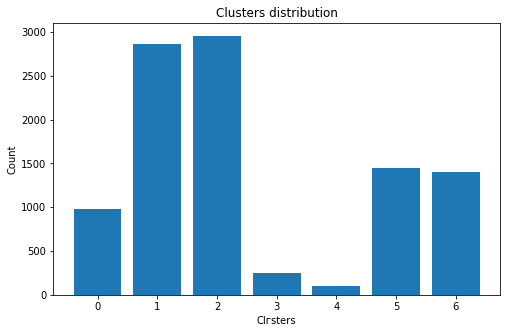

In [38]:
kmeans_7 = KMeans(n_clusters=7, random_state=33)
labels_clast_7 = kmeans_7.fit_predict(df_scaled)
labels_clast_7 = pd.Series(labels_clast_7, name='clusters_7')

unique, counts = np.unique(labels_clast_7, return_counts=True)
display_clusters_distribution(unique, counts)

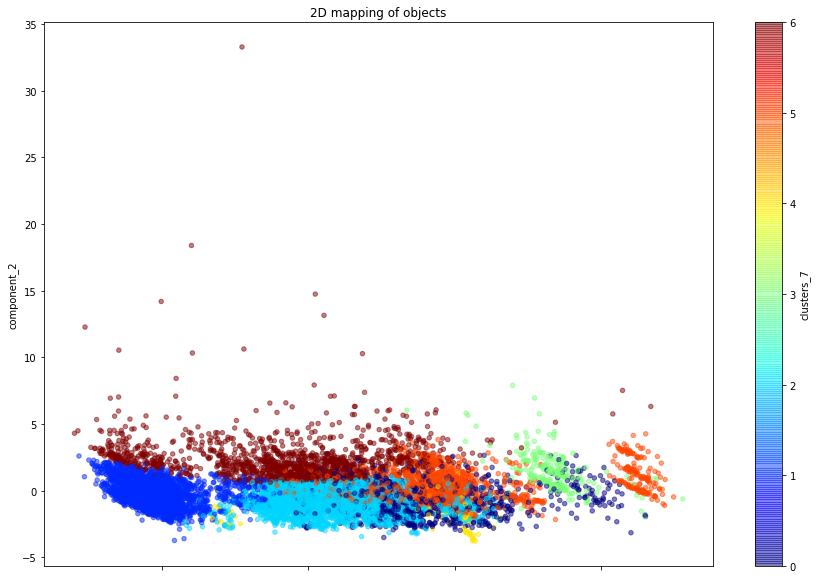

In [39]:
display_components_in_2D_space(components_2d, labels_clast_7)

СМОТРИМ КОРРЕЛЯЦИЮ ПРИЗНАКОВ

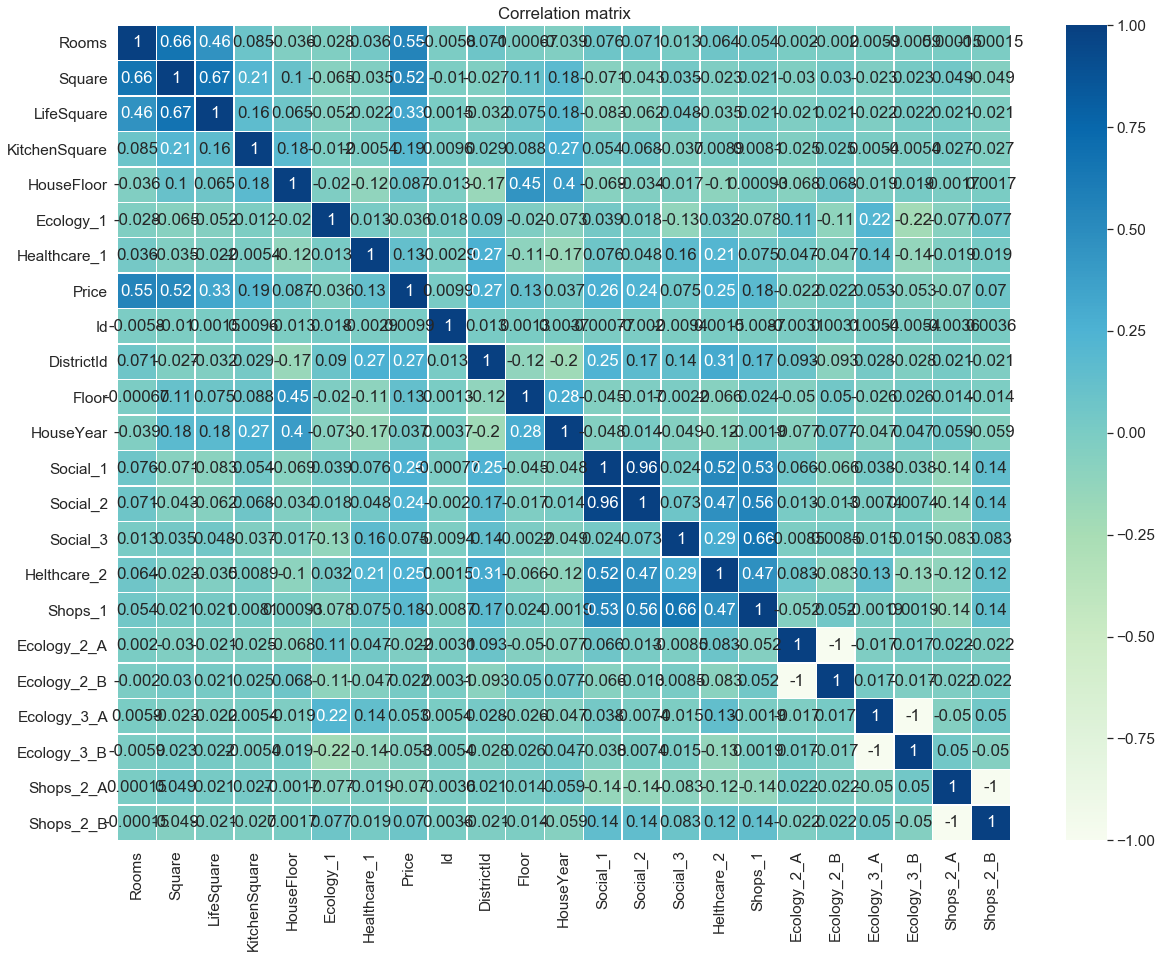

In [40]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

ОТБОР ПРИЗНАКОВ

In [41]:
train_df.columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1',
 'Price',
 'Id',
 'DistrictId',
 'Floor',
 'HouseYear',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [42]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
 'HouseFloor', 'Ecology_1', 'Healthcare_1', 'DistrictId', 'Floor', 'HouseYear', 'Social_1', 'Social_2',
 'Social_3', 'Helthcare_2', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']


target_name = 'Price'

In [43]:
X = train_df[feature_names]
y = train_df[target_name]

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [45]:
X_train

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1,DistrictId,Floor,HouseYear,Social_1,Social_2,Social_3,Helthcare_2,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
9185,1.0,39.837742,23.281368,7.0,17.0,0.007659,2301.0,156,13,2010,35,7077,56,3,0,1,0,1,0,1
6945,2.0,17.414181,32.781261,6.0,20.0,0.072158,900.0,62,4,1977,2,629,1,0,0,1,0,1,1,0
6615,1.0,44.846561,21.589865,8.0,14.0,0.075424,2672.0,138,3,2004,36,6714,2,0,0,1,0,1,0,1
9527,2.0,52.449860,27.145807,7.0,5.0,0.169091,900.0,124,3,1953,19,3856,10,2,0,1,0,1,0,1
4336,3.0,65.521545,39.973740,8.0,9.0,0.169091,900.0,124,5,1976,19,3856,10,2,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,1.0,38.476448,23.803303,9.0,14.0,0.092291,165.0,8,16,1971,21,4346,2,1,0,1,0,1,0,1
48,1.0,47.080101,46.807991,12.0,9.0,0.014073,900.0,23,3,1977,2,475,0,0,0,1,0,1,0,1
8964,3.0,74.132698,45.351234,10.0,17.0,0.025609,240.0,1,10,2009,33,5261,0,3,0,1,0,1,0,1
5944,2.0,63.911400,33.784615,12.0,17.0,0.188784,900.0,46,2,2004,31,6137,4,0,0,1,0,1,0,1


In [46]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

Train R2:	0.963
Valid R2:	0.714


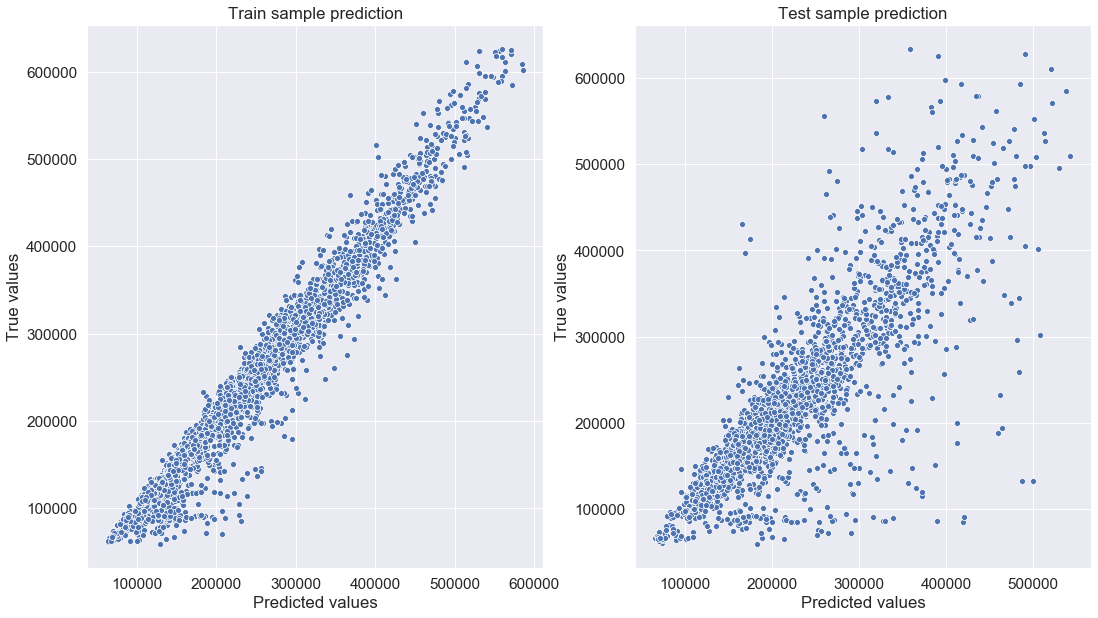

In [47]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_val)

evaluate_preds(y_train, y_train_preds, y_val, y_test_preds)

In [48]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=7, shuffle=True, random_state=21))
cv_score

array([0.77959668, 0.67338266, 0.70658944, 0.72849804, 0.7374648 ,
       0.73243853, 0.75428793])

In [49]:
cv_score.mean()

0.7303225816205867

In [50]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.398318
10,Social_1,0.109066
11,Social_2,0.085306
0,Rooms,0.078508
12,Social_3,0.056161
7,DistrictId,0.048936
9,HouseYear,0.036696
5,Ecology_1,0.036064
2,LifeSquare,0.031778
8,Floor,0.030451


ПОДГОТОКВА X_TEST

In [51]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [52]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


In [53]:
print(len(test_df) - test_df.count())
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64


Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [54]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['LifeSquare'].median()

In [55]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [56]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [57]:
test_df.loc[test_df['Ecology_1'] == 0, 'Ecology_1'] = test_df['Ecology_1'].median()

In [58]:
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [59]:
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = test_df['KitchenSquare'].median()

In [60]:
test_df.loc[test_df['KitchenSquare'] > 680, 'KitchenSquare'] = test_df['KitchenSquare'].median()

In [61]:
test_df.loc[test_df['LifeSquare'] > 680, 'LifeSquare'] = test_df['LifeSquare'].median()

In [62]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['Ecology_2'], prefix='Ecology_2')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Ecology_3'], prefix='Ecology_3')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Shops_2'], prefix='Shops_2')], axis=1)

In [63]:
test_df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [65]:
test_df.drop(['Ecology_2'], axis = 1, inplace = True)
test_df.drop(['Ecology_3'], axis = 1, inplace = True)
test_df.drop(['Shops_2'], axis = 1, inplace = True)
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Ecology_2_A        uint8
Ecology_2_B        uint8
Ecology_3_A        uint8
Ecology_3_B        uint8
Shops_2_A          uint8
Shops_2_B          uint8
dtype: object

In [83]:
X_test_final = test_df.drop(labels=['DistrictId'], axis=1)

In [84]:
X_test_final_clean = X_test_final.drop(labels=['Id'], axis=1)

In [86]:
y_test_preds = rf_model.predict(X_test_final_clean)

In [94]:
X_test_final_clean = pd.DataFrame({
    'Id': test_df.index,
    'Price': y_test_preds
})

In [95]:
X_test_final_clean.to_csv('VUSedko_predictions.csv', index=False, encoding='utf-8')